In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename));

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emnist/emnist-letters-mapping.txt
/kaggle/input/emnist/emnist-letters-test.csv
/kaggle/input/emnist/emnist-mnist-mapping.txt
/kaggle/input/emnist/emnist-digits-train.csv
/kaggle/input/emnist/emnist-bymerge-mapping.txt
/kaggle/input/emnist/emnist-balanced-train.csv
/kaggle/input/emnist/emnist-digits-test.csv
/kaggle/input/emnist/emnist-balanced-test.csv
/kaggle/input/emnist/emnist-mnist-test.csv
/kaggle/input/emnist/emnist-letters-train.csv
/kaggle/input/emnist/emnist-byclass-train.csv
/kaggle/input/emnist/emnist-bymerge-test.csv
/kaggle/input/emnist/emnist-balanced-mapping.txt
/kaggle/input/emnist/emnist-mnist-train.csv
/kaggle/input/emnist/emnist-digits-mapping.txt
/kaggle/input/emnist/emnist-bymerge-train.csv
/kaggle/input/emnist/emnist-byclass-test.csv
/kaggle/input/emnist/emnist-byclass-mapping.txt
/kaggle/input/emnist/emnist_source_files/emnist-digits-test-labels-idx1-ubyte
/kaggle/input/emnist/emnist_source_files/emnist-bymerge-train-labels-idx1-ubyte
/kaggle/input/

In this Kaggle notebook, we use a neural network to identify hand-written digits from the EMNIST dataset. The training set consists of 240,000 28x28 greyscale images each showing a single handwritten digit.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#import torchvision
#import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Import the data

In [3]:
train_df = pd.read_csv('/kaggle/input/emnist/emnist-digits-train.csv', header=None,dtype=np.uint8)
test_df = pd.read_csv('/kaggle/input/emnist/emnist-digits-test.csv', header=None,dtype=np.uint8)

We standard normalise to account for variation in pixel values across the dataset. We need to use float32 for the neural network.
We also transform the data into the shape Pytorch (Conv2d) expects i.e. Nx1x28x28. As these are grayscale images the number of channels is 1.
The last two dimensions are transposed to make the images upright when viewed using the standard upper-left-origin convention.

In [4]:
x_train=train_df.loc[:,1:].to_numpy().astype('float32')
x_train=((x_train.transpose()-x_train.mean(axis=1))/x_train.std(axis=1)).transpose()
x_train=x_train.reshape(x_train.shape[0],1,28,28).transpose(0,1,3,2)

y_train=train_df.loc[:,0].to_numpy().astype('uint8')

x_test=test_df.loc[:,1:].to_numpy().astype('float32')
x_test=((x_test.transpose()-x_test.mean(axis=1))/x_test.std(axis=1)).transpose()
x_test=x_test.reshape(x_test.shape[0],1,28,28).transpose(0,1,3,2)

y_test=test_df.loc[:,0].to_numpy().astype('uint8')

# View the data

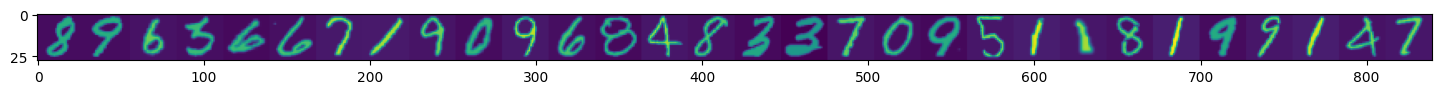

Ground truth [8 9 6 3 6 6 7 1 9 0 9 6 8 4 8 3 3 7 0 9 5 1 1 8 1 9 9 1 4 7]


In [5]:
# show the first few or some random digits
import random
n=30
#ind = [random.randrange(0, train_df.shape[0]) for p in range(0, n)]
ind=range(n)
img=x_train.transpose((2,3,0,1))[:,:,ind,0].reshape(28,n*28,order='F')# concatenate horizontally
fig, ax = plt.subplots(figsize=(18, 2))
plt.imshow(img)
plt.show()
print('Ground truth', y_train[ind])

# Define the neural network

We use a network topology that is a bit different from the original MNIST paper (LeCun et al 1988) in that we use greater numbers of output features (32 and 64 compared to 6 and 16) in the two convolutional layers.

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

      # First 2D convolutional layer. Takes in the grayscale (so channel dimension=1) 2D 28x28 images
      # outputting 32 convolutional features, with a square kernel size of 5
        self.conv1 = nn.Conv2d(1, 32, 5)
        
      # Second 2D convolutional layer, taking in the 32 input layers,
      # outputting 64 convolutional features, with a square kernel size of 5
        self.conv2 = nn.Conv2d(32, 64, 5)

        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        self.conv1_bn=nn.BatchNorm2d(32)
        self.conv2_bn=nn.BatchNorm2d(64)

      # First fully connected layer
        self.fc1 = nn.Linear(1024, 128)
      # Second fully connected layer that outputs our 10 labels
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):

        x = self.conv1(x)               #Nx1x28x28 -> Nx32x24x24
        x = self.conv1_bn(x)  #batch norm
        x = F.relu(x) 
        x = F.max_pool2d(x, 2)            ##Nx32x24x24 -> Nx32x12x12

        x = self.conv2(x)               #Nx32x12x12 -> Nx64x8x8
        x = self.conv2_bn(x)  #batch norm
        x = F.relu(x)
        x = F.max_pool2d(x, 2)            ##Nx64x8x8 -> Nx64x4x4
        
      # Pass data through dropout1
        x = self.dropout1(x)
      # Flatten x with start_dim=1
        x = torch.flatten(x, 1)
      # Pass data through ``fc1``
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

      # Apply softmax to x
      #x = F.log_softmax(x, dim=1) #not needed as nn.CrossEntropyLoss() takes in logits
        return x

my_nn = Net()
print(my_nn)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# Pass through data to test

In [9]:
input=torch.tensor(x_train[0,0,:,:],dtype=torch.float32)# convert to tensor of floats
input=torch.unsqueeze(input,0)#channel dimension, 1 for grayscale
input=torch.unsqueeze(input,0)#batch dimension
print(input.shape)
result = my_nn(input)
print(result)

torch.Size([1, 1, 28, 28])
tensor([[ 0.4757,  0.2227,  0.4448, -0.1454,  0.3050,  1.0231, -0.1259,  0.8127,
          0.3274, -1.2798]], grad_fn=<AddmmBackward0>)


# Define the loss function

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_nn.parameters(), lr=0.001, momentum=0.9)

# Train the model

First, move the model to the GPU if available

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
my_nn.to(device);

cuda:0


In [17]:
n_epochs=40
accuracy_train=np.zeros(n_epochs,)
accuracy_test=np.zeros(n_epochs,)

In [ ]:
#to extend the run
#n_epochs=40
#accuracy_train=np.append(accuracy_train,np.zeros(20,))
#accuracy_test=np.append(accuracy_test,np.zeros(20,))

We train the model for several epochs. Afer each epoch, we run model on the train and test data and determine its accuracy.
The batch size can be set to several thousand before running out of GPU memory. However, this leads to a very slow learning rate since backpropogation and optimaisation only occurs after each batch.

In [19]:
batch_size=100

all_predictions=np.ndarray((240000,),dtype='int64')
all_predictions_test=np.ndarray((x_test.shape[0],),dtype='int64')


for epoch in range(n_epochs):  # loop over the dataset multiple times
    
    my_nn.train()
    
    running_loss = 0.0
    for i in range(0,240000,batch_size):
        
        batch=torch.tensor(x_train[i:(i+batch_size),0,:,:],dtype=torch.float32).to(device)
        batch=torch.unsqueeze(batch,1)
        labels=torch.tensor(y_train[i:(i+batch_size)],dtype=torch.long).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = my_nn(batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        # print statistics
        running_loss += loss.item()
        if i% 60000 == 0:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            

#after each epoch, run again on the training and test data
    my_nn.eval()
    with torch.no_grad():
        for i in range(0,x_train.shape[0],batch_size):
            batch=torch.tensor(x_train[i:(i+batch_size),0,:,:],dtype=torch.float32).to(device)
            batch=torch.unsqueeze(batch,1)
            outputs = my_nn(batch)
            _, batch_predictions = torch.max(outputs.data, 1)
            all_predictions[i:(i+batch_size)]=batch_predictions.cpu().numpy()
        
        accuracy_train[epoch]=sum(y_train==all_predictions)/x_train.shape[0]
        
        for i in range(0,x_test.shape[0],batch_size):
            batch=torch.tensor(x_test[i:(i+batch_size),0,:,:],dtype=torch.float32).to(device)
            batch=torch.unsqueeze(batch,1)
            #labels=torch.tensor(y_train[i:(i+batch_size)],dtype=torch.long).to(device)
            outputs = my_nn(batch)
            _, batch_predictions = torch.max(outputs.data, 1)
            all_predictions_test[i:(i+batch_size)]=batch_predictions.cpu().numpy()
        accuracy_test[epoch]=sum(y_test==all_predictions_test)/x_test.shape[0]
    
    print(f'[{epoch + 1}, {i + 1:5d}] training accuracy: {accuracy_train[epoch]}, test accuracy: {accuracy_test[epoch]}')

print('Finished Training')

[1,     1] loss: 0.001
[1, 60001] loss: 0.180
[1, 120001] loss: 0.054
[1, 180001] loss: 0.037
[1, 39901] training accuracy: 0.9857458333333333, test accuracy: 0.9857
[2,     1] loss: 0.000
[2, 60001] loss: 0.027
[2, 120001] loss: 0.024
[2, 180001] loss: 0.022
[2, 39901] training accuracy: 0.9897, test accuracy: 0.989175
[3,     1] loss: 0.000
[3, 60001] loss: 0.021
[3, 120001] loss: 0.018
[3, 180001] loss: 0.017
[3, 39901] training accuracy: 0.9913875, test accuracy: 0.99115
[4,     1] loss: 0.000
[4, 60001] loss: 0.017
[4, 120001] loss: 0.015
[4, 180001] loss: 0.015
[4, 39901] training accuracy: 0.99235, test accuracy: 0.9925
[5,     1] loss: 0.000
[5, 60001] loss: 0.015
[5, 120001] loss: 0.014
[5, 180001] loss: 0.013
[5, 39901] training accuracy: 0.9932375, test accuracy: 0.993075
[6,     1] loss: 0.000
[6, 60001] loss: 0.013
[6, 120001] loss: 0.013
[6, 180001] loss: 0.012
[6, 39901] training accuracy: 0.9937125, test accuracy: 0.9935
[7,     1] loss: 0.000
[7, 60001] loss: 0.013
[7,

In [20]:
accuracy_test

array([0.9857  , 0.989175, 0.99115 , 0.9925  , 0.993075, 0.9935  ,
       0.993875, 0.9942  , 0.99455 , 0.994675, 0.994675, 0.994875,
       0.99525 , 0.995375, 0.995325, 0.995375, 0.9953  , 0.99535 ,
       0.995475, 0.995525, 0.99545 , 0.99545 , 0.995525, 0.9956  ,
       0.99535 , 0.99565 , 0.99575 , 0.9956  , 0.995775, 0.9955  ,
       0.995775, 0.995625, 0.99585 , 0.9956  , 0.995825, 0.9959  ,
       0.9957  , 0.99555 , 0.99585 , 0.995825])

Save the model

In [21]:
PATH = '/kaggle/working/my_nn.pth'
torch.save(my_nn.state_dict(), PATH)

Load the model

In [ ]:
PATH = '/kaggle/working/my_nn.pth'
my_nn = Net()
my_nn.load_state_dict(torch.load(PATH))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


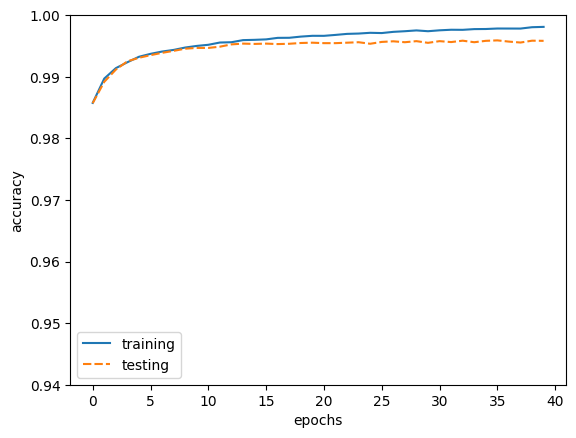

In [22]:
import seaborn as sns

ax=sns.lineplot(pd.DataFrame({'training':accuracy_train,'testing':accuracy_test },index=range(n_epochs)));
ax.set_ylim(0.94,1);
ax.set_ylabel('accuracy');
ax.set_xlabel('epochs');

# View the predictions

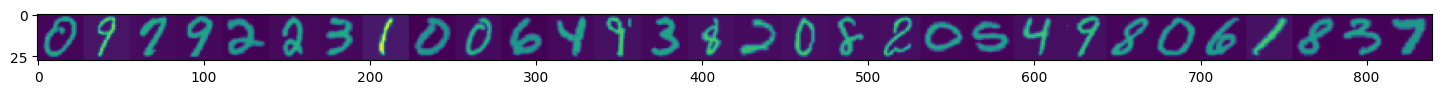

Ground truth [0 9 7 9 2 2 3 1 0 0 6 4 9 3 8 2 0 8 2 0 5 4 9 8 0 6 1 8 3 7]


In [23]:
# show some random digits
n=30
ind = [random.randrange(0, y_test.shape[0]) for p in range(0, n)]
ind=range(n)
img=x_test.transpose((2,3,0,1))[:,:,ind,0].reshape(28,n*28,order='F')# concatenate horizontally
fig, ax = plt.subplots(figsize=(18, 2))
plt.imshow(img)
plt.show()
print('Ground truth', y_test[ind])

In [25]:
err=y_test!=all_predictions_test
sum(err)

167

Let's view some of the 167 digits out of 40000 that were incorrectly classified

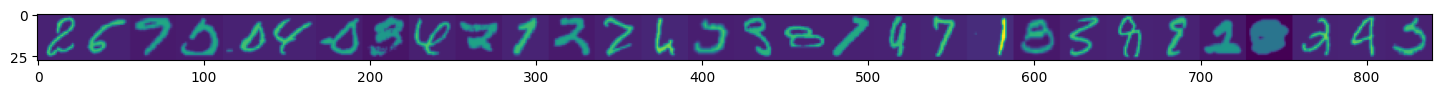

Ground truth [2 6 9 2 0 8 0 3 6 3 1 2 2 4 5 3 8 7 9 4 1 8 3 8 9 1 0 2 4 3]
Prediction [8 5 7 5 6 4 6 9 4 2 7 3 7 6 3 8 9 1 4 7 4 9 5 9 8 2 8 3 9 5]


In [24]:
n=30
err_ind=[i for i, x in enumerate(err) if x]
ind=err_ind[:n]
img=x_test.transpose((2,3,0,1))[:,:,ind,0].reshape(28,n*28,order='F')# concatenate horizontally
fig, ax = plt.subplots(figsize=(18, 2))
plt.imshow(img)
plt.show()
print('Ground truth', y_test[ind])
print('Prediction', all_predictions_test[ind])

Some of the errors are understandable